In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

In [119]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

In [120]:
cursor.executescript(open("bike_store_sales.sql", "r").read())

In [121]:
df = pd.read_sql("SELECT * FROM sales ORDER BY date;", conn)
cursor.close()
conn.close()
df.head()

,date,age,sex,country,state,product_category,sub_category,product,order_quantity,unit_cost,unit_price,profit,cost,revenue
0,2011-01-01,23,M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",1,1252,2295,561,1252,1813
1,2011-01-01,33,F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,1097,4342,5439
2,2011-01-01,17,M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",1,1519,2443,900,1519,2419
3,2011-01-01,42,M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",1,344,540,185,344,529
4,2011-01-01,39,M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",3,713,1120,482,2139,2621


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95806 entries, 0 to 95805
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              95806 non-null  object
 1   age               95806 non-null  int64 
 2   sex               95806 non-null  object
 3   country           95806 non-null  object
 4   state             95806 non-null  object
 5   product_category  95806 non-null  object
 6   sub_category      95806 non-null  object
 7   product           95806 non-null  object
 8   order_quantity    95806 non-null  int64 
 9   unit_cost         95806 non-null  int64 
 10  unit_price        95806 non-null  int64 
 11  profit            95806 non-null  int64 
 12  cost              95806 non-null  int64 
 13  revenue           95806 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 10.2+ MB


In [123]:
df[["order_quantity", "unit_cost", "unit_price", "profit", "cost", "revenue"]].describe()

,order_quantity,unit_cost,unit_price,profit,cost,revenue
count,95806.000000,95806.000000,95806.000000,95806.000000,95806.000000,95806.000000
mean,11.851888,273.024967,465.543703,297.577427,489.972069,787.549496
std,9.548278,559.864796,944.059238,466.133558,895.135997,1330.468420
min,1.000000,1.000000,2.000000,-30.000000,1.000000,2.000000
25%,2.000000,2.000000,5.000000,32.000000,33.000000,74.000000
50%,10.000000,11.000000,30.000000,114.000000,126.000000,253.000000
75%,20.000000,42.000000,70.000000,368.000000,456.000000,840.000000
max,32.000000,2171.000000,3578.000000,5638.000000,8684.000000,14312.000000


Re-casting to appropriate values to reduce memory usage

In [124]:
df["age"] = df["age"].astype(np.uint8)
df["order_quantity"] = df["order_quantity"].astype(np.uint8)
df["unit_cost"] = df["unit_cost"].astype(np.uint16)
df["unit_price"] = df["unit_price"].astype(np.uint16)
df["profit"] = df["profit"].astype(np.int32)
df["cost"] = df["cost"].astype(np.uint16)
df["revenue"] = df["revenue"].astype(np.uint16)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95806 entries, 0 to 95805
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              95806 non-null  object
 1   age               95806 non-null  uint8 
 2   sex               95806 non-null  object
 3   country           95806 non-null  object
 4   state             95806 non-null  object
 5   product_category  95806 non-null  object
 6   sub_category      95806 non-null  object
 7   product           95806 non-null  object
 8   order_quantity    95806 non-null  uint8 
 9   unit_cost         95806 non-null  uint16
 10  unit_price        95806 non-null  uint16
 11  profit            95806 non-null  int32 
 12  cost              95806 non-null  uint16
 13  revenue           95806 non-null  uint16
dtypes: int32(1), object(7), uint16(4), uint8(2)
memory usage: 6.4+ MB


# Gender related sales exploration
___

In [126]:
countrygroup = df.groupby(by="country")

In [127]:
pd.DataFrame(countrygroup["sex"].value_counts(normalize=True).multiply(100).round(2)).rename({"sex": "% of sales"}, axis="columns")

% of sales
country        sex            
Australia      M         51.47
               F         48.53
Canada         M         53.94
               F         46.06
France         F         50.30
               M         49.70
Germany        M         50.58
               F         49.42
United Kingdom M         50.36
               F         49.64
United States  M         52.28
               F         47.72

In [128]:
countries = list(df["country"].unique())
men = []
women = []
for country in countries:
    _men, _women = countrygroup["sex"].get_group(country).value_counts().multiply(100).round(2)
    men.append(_men)
    women.append(_women)

In [129]:
def insert_labels(bars) -> None:
    """Insert a text label above each bar in the barchart given."""
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:,}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

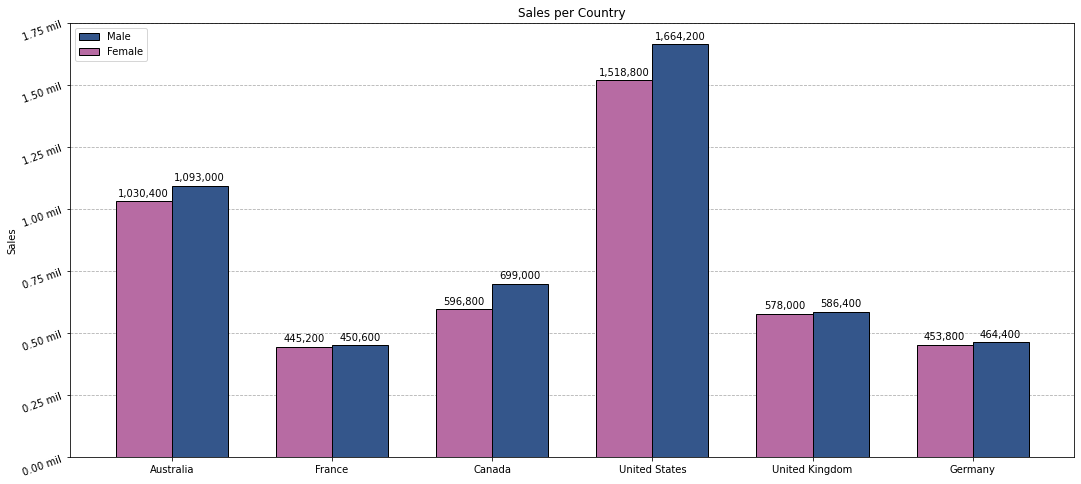

In [130]:
y_axis = np.arange(0, 2e6, 250_000)
x_axis = np.arange(len(countries))
width= 0.35

fig, ax = plt.subplots(figsize=(18, 8))

ax.grid(axis="y", which="major", linestyle="--", zorder=0)
men_bars = ax.bar(x_axis + width / 2, men, width, zorder=3, color="#34568b", edgecolor="black", label="Male")
insert_labels(men_bars)

women_bars = ax.bar(x_axis - width / 2, women, width, zorder=3, color="#b76ba3", edgecolor="black", label="Female")
insert_labels(women_bars)

ax.set_xticks(ticks=x_axis, labels=countries)
ax.set_yticks(ticks=y_axis, labels=[f"{sales / 1e6:.2f} mil" for sales in y_axis], rotation=20)
ax.set_title("Sales per Country")
ax.set_xlabel("")
ax.set_ylabel("Sales")
ax.legend(loc="upper left")

- Canada and US male sales prevail
- In the other countries the difference is insignificant

Let's have a look at these groups' purchases

In [131]:
us_cat_group = df.loc[df["country"] == "United States"].groupby("product_category")
can_cat_group = df.loc[df["country"] == "Canada"].groupby("product_category")

In [132]:
categories = list(df["product_category"].unique())
us_men = []
us_women = []
can_men = []
can_women = []
for category in categories:
    _men, _women = us_cat_group["sex"].get_group(category).value_counts().multiply(100).round(2)
    us_men.append(_men)
    us_women.append(_women)

    _men, _women = can_cat_group["sex"].get_group(category).value_counts().multiply(100).round(2)
    can_men.append(_men)
    can_women.append(_women)

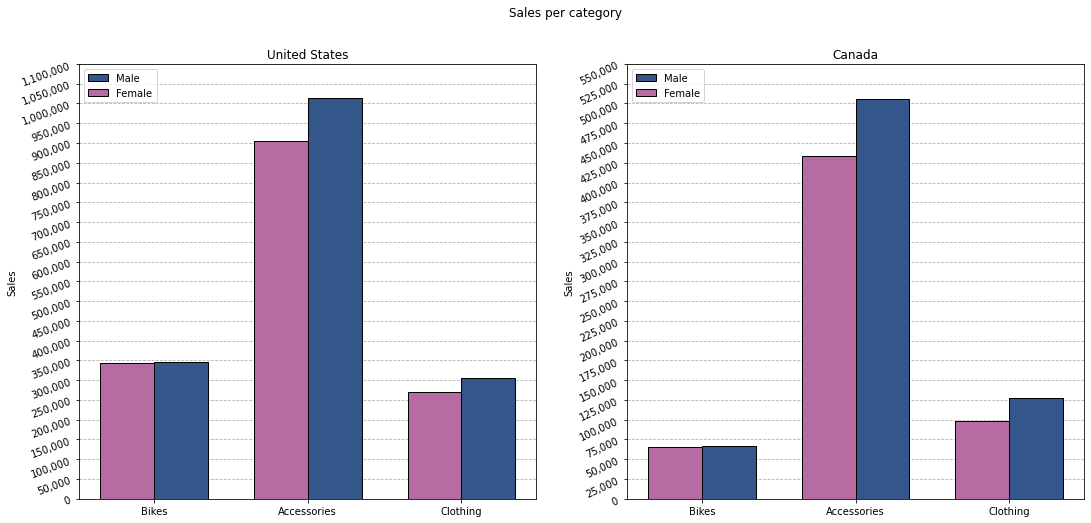

In [133]:
x_axis = np.arange(len(categories))
us_y_axis = np.arange(0, 1_100_001, 50_000)
can_y_axis = np.arange(0, 550_001, 25_000)
width= 0.35

fig, (us_ax, can_ax) = plt.subplots(ncols=2, figsize=(18, 8))
fig.suptitle("Sales per category")

# United States

us_ax.grid(axis="y", which="major", linestyle="--", zorder=0)
us_ax.bar(x_axis + width / 2, us_men, width, zorder=3, color="#34568b", edgecolor="black", label="Male")
us_ax.bar(x_axis - width / 2, us_women, width, zorder=3, color="#b76ba3", edgecolor="black", label="Female")

us_ax.set_xticks(ticks=x_axis, labels=categories)
us_ax.set_yticks(ticks=us_y_axis, labels=[f"{int(sales):,}" for sales in us_y_axis], rotation=20)
us_ax.set_title("United States")
us_ax.set_ylabel("Sales")
us_ax.legend(loc="upper left")

# Canada

can_ax.grid(axis="y", which="major", linestyle="--", zorder=0)
can_ax.bar(x_axis + width / 2, can_men, width, zorder=3, color="#34568b", edgecolor="black", label="Male")
can_ax.bar(x_axis - width / 2, can_women, width, zorder=3, color="#b76ba3", edgecolor="black", label="Female")

can_ax.set_xticks(ticks=x_axis, labels=categories)
can_ax.set_yticks(ticks=can_y_axis, labels=[f"{int(sales):,}" for sales in can_y_axis], rotation=25)
can_ax.set_title("Canada")
can_ax.set_ylabel("Sales")
can_ax.legend(loc="upper left")

- Men in both the US and Canada buy more accessories and clothing than women

# Category sales percentage by country
___

In [134]:
country_cat_perc = pd.DataFrame(df.groupby("country")["product_category"].value_counts(normalize=True).multiply(100).round(2))
country_cat_perc.columns = ["% of total sales per country"]
country_cat_perc

% of total sales per country
country        product_category                              
Australia      Accessories                              55.55
               Bikes                                    29.48
               Clothing                                 14.97
Canada         Accessories                              72.40
               Clothing                                 17.39
               Bikes                                    10.20
France         Accessories                              57.47
               Bikes                                    26.28
               Clothing                                 16.25
Germany        Accessories                              56.96
               Bikes                                    27.58
               Clothing                                 15.47
United Kingdom Accessories                              58.57
               Bikes                                    25.13
               Clothing                                 16.30
United States  Accessories                              60.25
               Bikes                                    21.65
               Clothing                                 18.11

In [135]:
country_cat_perc.reset_index(inplace=True)

acc_perc = country_cat_perc.loc[country_cat_perc["product_category"] == "Accessories"].drop("product_category", axis="columns").set_index("country")
acc_perc.columns = ["%"]

bike_perc = country_cat_perc.loc[country_cat_perc["product_category"] == "Bikes"].drop("product_category", axis="columns").set_index("country")
bike_perc.columns = ["%"]

cloth_perc = country_cat_perc.loc[country_cat_perc["product_category"] == "Clothing"].drop("product_category", axis="columns").set_index("country")
cloth_perc.columns = ["%"]

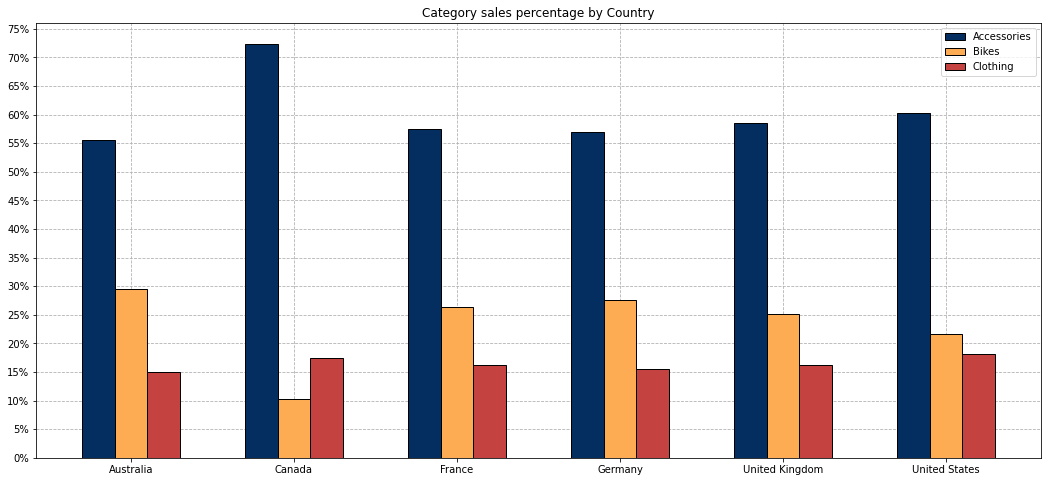

In [136]:
x_axis = np.arange(len(bike_perc))
y_axis = np.arange(0, 76, 5)
width = 0.20

plt.figure(figsize=(18, 8))

plt.grid(which="major", linestyle="--", zorder=0)
plt.bar(x_axis - width, acc_perc["%"], width, color="#042e60", edgecolor="black", zorder=3, label="Accessories")
plt.bar(x_axis, bike_perc["%"], width, color="#fdac53", edgecolor="black", zorder=3, label="Bikes")
plt.bar(x_axis + width, cloth_perc["%"], width, color="#c44240", edgecolor="black", zorder=3, label="Clothing")

plt.xticks(ticks=x_axis, labels=bike_perc.index)
plt.yticks(ticks=y_axis, labels=[f"{perc}%" for perc in y_axis])
plt.title("Category sales percentage by Country")

plt.legend()

- Australia, Germany & France sell more bikes compared to the rest of the countries
- Canada has a very low percentage of bike sales while a high percentage of accessory sales

# Sales by age group
___

In [137]:
df[["age"]].agg(["min", "max"])

,age
min,17
max,87


Text(0, 0.5, 'Number of Sales')

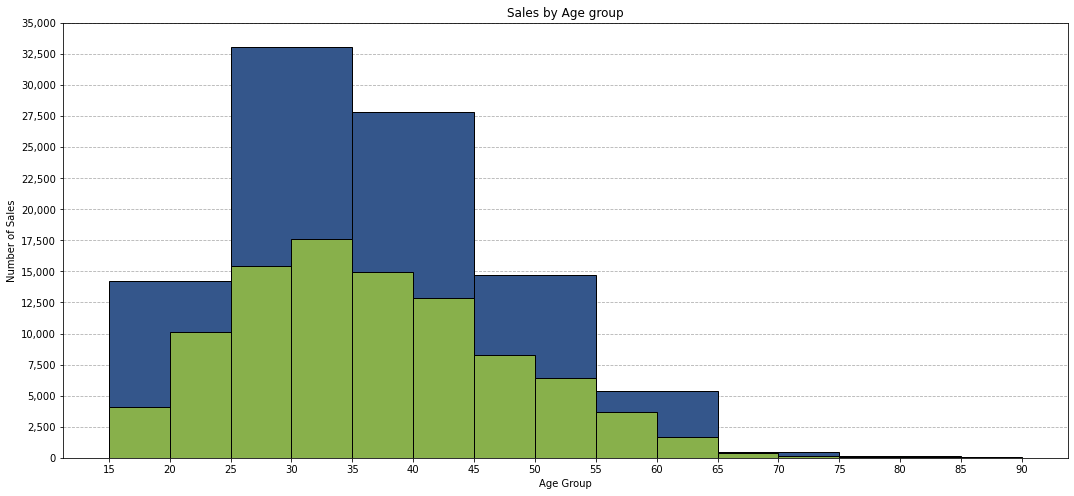

In [138]:
age_groups = np.arange(15, 91, 5)
big_age_groups = np.arange(15, 91, 10)
y_axis = np.arange(0, 35_001, 2_500)

fig, ax = plt.subplots(figsize=(18, 8))

ax.grid(which="major", axis="y", linestyle="--", zorder=0)
ax.hist(df["age"], bins=big_age_groups, color="#34568b", edgecolor="black", zorder=2)
ax.hist(df["age"], bins=age_groups, color="#88b04b", edgecolor="black", zorder=3)

ax.set_xticks(ticks=age_groups)
ax.set_yticks(ticks=y_axis, labels=[f"{sales:,}" for sales in y_axis])
ax.set_title("Sales by Age group")
ax.set_xlabel("Age Group")
ax.set_ylabel("Number of Sales")

In [139]:
100 * df.loc[ ( df["age"] > 24 ) & ( df["age"] < 46 ) ].shape[0] / df.shape[0]

65.44892804208504

In [140]:
100 * df.loc[ ( df["age"] < 25 ) | ( ( df["age"] > 45 ) & ( df["age"] < 56 ) ) ].shape[0] / df.shape[0]

29.45118259816713

- 65.45% of the customers are between the age of 25 to 45
- 29.45% of the customers are either 15-25 or 45-55

# Sales by date
___
Each row in the database represents a single sale, to a single customer.  
To explore the sales by date, I'll group by date and calculate the summary of the profit, cost and revenue by day

In [141]:
tdf = pd.DataFrame(df.groupby("date").sum().drop(["age", "order_quantity", "unit_cost", "unit_price"], axis="columns"))
tdf.index = pd.to_datetime(tdf.index)
tdf.head()

,profit,cost,revenue
date,,,
2011-01-01,3225,9596.0,12821.0
2011-01-02,2925,8943.0,11868.0
2011-01-03,12174,19001.0,31175.0
2011-01-04,6240,12669.0,18909.0
2011-01-05,1644,3031.0,4675.0


The dataframe is grouped by month

In [142]:
mdf = tdf.resample("M").sum()
mdf

,profit,cost,revenue
date,,,
2011-01-31,212849,462344.0,675193.0
2011-02-28,207144,430454.0,637598.0
2011-03-31,226404,482113.0,708517.0
2011-04-30,223601,475181.0,698782.0
2011-05-31,234689,499848.0,734537.0
...,...,...,...
2016-03-31,861469,1281724.0,2143193.0
2016-04-30,920252,1357716.0,2277968.0
2016-05-31,1063010,1576388.0,2639398.0


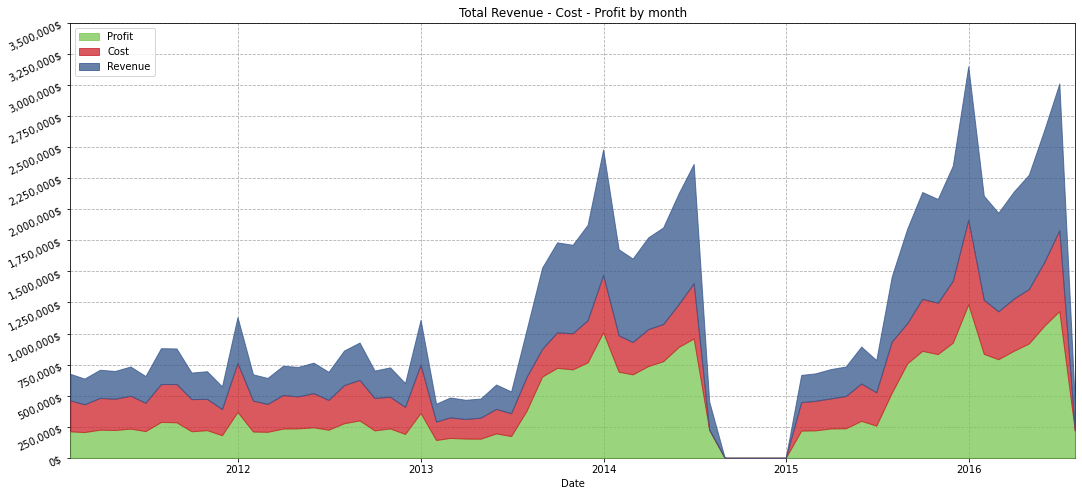

In [143]:
fig, ax = plt.subplots(figsize=(18, 8))

y_axis = np.arange(0, 3_500_501, 250_000)

ax.grid(which="both", linestyle="--", zorder=0)
ax.fill_between(mdf.index, mdf["profit"], 0, zorder=3, color="#79c753", alpha=0.75, label="Profit")
ax.fill_between(mdf.index, mdf["profit"], mdf["cost"], zorder=3, color="#cd212a", alpha=0.75, label="Cost")
ax.fill_between(mdf.index, mdf["cost"], mdf["revenue"], zorder=3, color="#34568b", alpha=0.75, label="Revenue")

ax.set_yticks(ticks=y_axis, labels=[f"{usd:,}$" for usd in y_axis], rotation=25)
ax.set_xlim([mdf.index[0], mdf.index[-1]])
ax.set_ylim(0)
ax.set_title("Total Revenue - Cost - Profit by month")
ax.set_xlabel("Date")
ax.legend(loc="upper left")

- Every new years' eve there seems to be a consistent spike in sales
- The overall profit has increased

In [144]:
tdf.loc[tdf.index.year == 2014].resample("M").sum()

,profit,cost,revenue
date,,,
2014-01-31,692563,985899.0,1678462.0
2014-02-28,671502,931785.0,1603287.0
2014-03-31,738322,1035460.0,1773782.0
2014-04-30,777583,1076611.0,1854194.0
2014-05-31,892175,1237008.0,2129183.0
2014-06-30,960162,1404870.0,2365032.0
2014-07-31,226792,227126.0,453918.0


There are missing sales during the 5 last months of 2014

# Total Revenue - Cost - Profit by country
___

In [145]:
earnings_table = countrygroup[["revenue", "cost", "profit"]].sum().sort_values(by="profit", ascending=False)
earnings_table

,revenue,cost,profit
country,,,
United States,24571859.0,14887097.0,9684762
Australia,19366318.0,13199506.0,6166812
United Kingdom,9082515.0,5281481.0,3801034
Canada,7262193.0,3837846.0,3424347
Germany,7779075.0,4864780.0,2914295
France,7390007.0,4871554.0,2518453


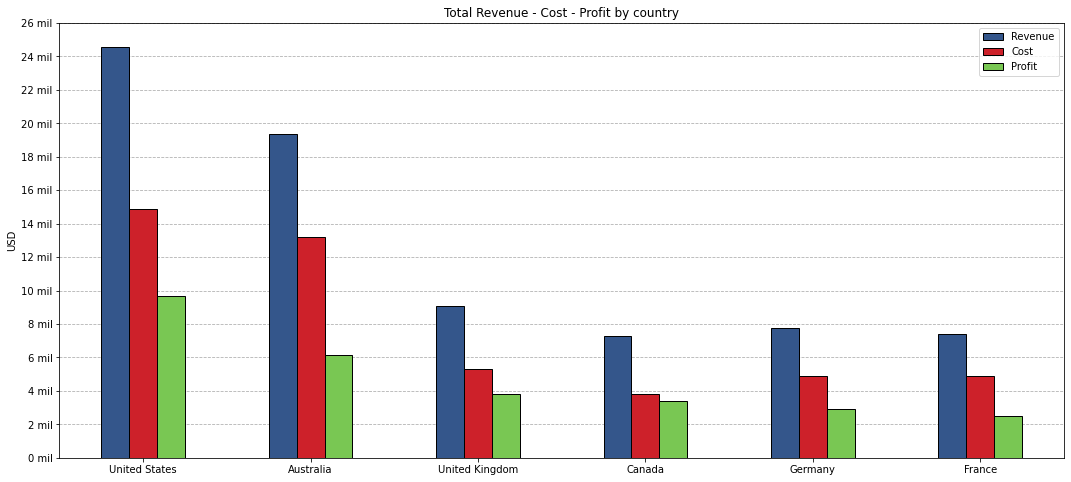

In [146]:
fig, ax = plt.subplots(figsize=(18, 8))

x_axis = np.arange(len(countries))
y_axis = np.arange(0, 26_000_001, 2_000_000)

earnings_table.plot.bar(color=["#34568b", "#cd212a", "#79c753"], edgecolor="black", rot=0, zorder=3, ax=ax)
ax.grid(which="major", axis="y", linestyle="--", zorder=0)

ax.set_xticks(ticks=x_axis, labels=earnings_table.index)
ax.set_yticks(ticks=y_axis, labels=[f"{usd / 1e6:.0f} mil" for usd in y_axis])
ax.set_title("Total Revenue - Cost - Profit by country")
ax.set_xlabel("")
ax.set_ylabel("USD")
ax.legend(["Revenue", "Cost", "Profit"], loc="upper right")

- Australias' product cost over profit ratio is high

In [147]:
earnings_table["revenue"] = round(earnings_table["revenue"] / 1e6, 2)
earnings_table["cost"] = round(earnings_table["cost"] / 1e6, 2)
earnings_table["profit"] = round(earnings_table["profit"] / 1e6, 2)

earnings_table["Cost (% of Revenue)"] = round(100 * earnings_table["cost"] / earnings_table["revenue"], 2)
earnings_table["Profit (% of Revenue)"] = round(100 * earnings_table["profit"] / earnings_table["revenue"], 2)
earnings_table["Profit/Cost (%)"] = round(100 * earnings_table["profit"] / earnings_table["cost"], 2)

earnings_table.rename({"revenue": "Revenue (mil)", "cost": "Cost (mil)", "profit": "Profit (mil)", "revenue": "Revenue (mil)"}, axis="columns", inplace=True)
earnings_table = earnings_table[["Revenue (mil)", "Cost (mil)", "Cost (% of Revenue)", "Profit (mil)", "Profit (% of Revenue)", "Profit/Cost (%)"]]

earnings_table.sort_values(by="Profit/Cost (%)", ascending=False)

,Revenue (mil),Cost (mil),Cost (% of Revenue),Profit (mil),Profit (% of Revenue),Profit/Cost (%)
country,,,,,,
Canada,7.26,3.84,52.89,3.42,47.11,89.06
United Kingdom,9.08,5.28,58.15,3.80,41.85,71.97
United States,24.57,14.89,60.60,9.68,39.40,65.01
Germany,7.78,4.86,62.47,2.91,37.40,59.88
France,7.39,4.87,65.90,2.52,34.10,51.75
Australia,19.37,13.20,68.15,6.17,31.85,46.74


- 68.15% of Australias' revenue (13.2 out of 19.37 million USD) is the cost of the products sold
- 65.9% of Frances' revenue (4.87 out of 7.39 million USD) is the cost of the products sold

Both of these countries sell more bikes compared to others.  
Additionally, Canada sells an extremely low amount of bikes, and has the highest profit compared to its' revenue

Let's check the bike prices

In [148]:
bike_df = df.loc[df["product_category"] == "Bikes", ["product", "unit_cost", "unit_price"]]

bike_df["product"] = bike_df["product"].str.replace(", \d{2}", "", regex=True)
bike_df.drop_duplicates(inplace=True)

bike_df["Profit per Unit"] = bike_df["unit_price"] - bike_df["unit_cost"]
bike_df["Profit (%)"] = round(100 * bike_df["Profit per Unit"] / bike_df["unit_cost"], 2)

bike_df.rename({"product": "Product", "unit_cost": "Unit Cost", "unit_price": "Unit Price"}, axis="columns", inplace=True)
bike_df.sort_values(by="Profit (%)", inplace=True)
bike_df.index = range(bike_df.shape[0])

bike_df

,Product,Unit Cost,Unit Price,Profit per Unit,Profit (%)
0,Road-150 Red,2171,3578,1407,4.43
1,Mountain-100 Black,1898,3375,1477,8.76
2,Mountain-100 Silver,1912,3400,1488,9.27
3,Road-250 Red,1555,2443,888,14.96
4,Road-250 Black,1555,2443,888,14.96
5,Road-250 Red,1519,2443,924,17.69
6,Mountain-200 Black,1252,2295,1043,30.96
7,Mountain-200 Silver,1266,2320,1054,31.49
8,Road-750 Black,344,540,196,56.98
9,Road-350-W Yellow,1083,1701,618,57.06


- The profit from bike sales ranges from 4.43% to 83.44%

The bike prices might need adjusting

# Losses
___

In [149]:
loss = df.loc[df["profit"] < 0]
loss.head()

,date,age,sex,country,state,product_category,sub_category,product,order_quantity,unit_cost,unit_price,profit,cost,revenue
7920,2013-07-22,45,F,France,Yveline,Clothing,Jerseys,"Short-Sleeve Classic Jersey, S",25,42,54,-24,1050,1026
12640,2013-09-12,22,M,France,Yveline,Clothing,Caps,AWC Logo Cap,4,7,9,-1,28,27
13140,2013-09-16,25,M,France,Yveline,Clothing,Caps,AWC Logo Cap,18,7,9,-3,126,123
15793,2013-10-09,31,M,France,Yveline,Clothing,Caps,AWC Logo Cap,13,7,9,-2,91,89
15819,2013-10-09,31,M,France,Yveline,Clothing,Jerseys,"Short-Sleeve Classic Jersey, L",26,42,54,-25,1092,1067


In [150]:
loss.loc[loss["country"] != "France"]

,date,age,sex,country,state,product_category,sub_category,product,order_quantity,unit_cost,unit_price,profit,cost,revenue


In [151]:
loss.loc[loss["state"] != "Yveline"]

,date,age,sex,country,state,product_category,sub_category,product,order_quantity,unit_cost,unit_price,profit,cost,revenue


In [152]:
loss.loc[loss["product_category"] != "Clothing"]

,date,age,sex,country,state,product_category,sub_category,product,order_quantity,unit_cost,unit_price,profit,cost,revenue


In [153]:
loss["product"].unique()

array(['Short-Sleeve Classic Jersey, S', 'AWC Logo Cap',
       'Short-Sleeve Classic Jersey, L',
       'Short-Sleeve Classic Jersey, XL',
       'Short-Sleeve Classic Jersey, M'], dtype=object)

In [154]:
loss["profit"].sum()

-410

### Clothing in Yveline, France has been causing loss
Specifically:
- Short-Sleeve Classic Jersey
- AWC Logo Cap

In [155]:
pd.DataFrame(loss.loc[loss["product"].str.startswith("Short-Sleeve"),
            ["order_quantity", "unit_cost", "unit_price", "profit"]].sum()).rename({0: "Short-Sleeve Calssic Jersey"}, axis="columns")

,Short-Sleeve Calssic Jersey
order_quantity,311
unit_cost,672
unit_price,864
profit,-297


In [156]:
pd.DataFrame(loss.loc[loss["product"].str.startswith("AWC Logo"),
            ["order_quantity", "unit_cost", "unit_price", "profit"]].sum()).rename({0: "AWC Log Cap"}, axis="columns")

,AWC Log Cap
order_quantity,704
unit_cost,294
unit_price,378
profit,-113


# Conclusions
___
- Every new years' eve there's a spike in sales
- 65.45% of the customers are between the age of 25 to 45
- 29.45% of the customers are either 15-25 or 45-55
- Bike prices need adjusting to become more profitable
- *Short-Sleeve Classic Jersey* & *AWC Logo Cap* in **Yveline**, **France** have been causing loss
- Men in the **United States** & **Canada** buy more accessories
- **Australia**, **Germany** & **France** sell more bikes